# Measure variant fitness effect by combining DESeq2 measurements in weighted least squares (WLS) regression

DESeq2 logFC estimates from individual barcodes are fitted into a weighted linear regression to measure variant fitness effects and identify significant GxG interactions.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.robust.scale import mad
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.formula.api import wls
from statsmodels.stats.multitest import multipletests

In [2]:
working_dir="/home/users/rang/scratch/yeast/crispey3/gxg_5comp_aug2021/"
os.chdir(working_dir)

## Functions

In [3]:
def robust_outlier_removal(umi_df, fc_cutoff=3.5, basemean_cutoff=5):
    '''
    accepts a dataframe of deseq results and removes outliers based on log2FoldChange or baseMean values
    filters log2FoldChange by robust MADs - shrinks variance in logFC values
    filters baseMean by simple X-fold cutoff above median - reduces dependence on high leverage barcodes
    adjust cutoffs as necessary
    '''
    if len(umi_df)==1:
        return umi_df
    
    indices = umi_df.index.values
    fcs = umi_df['log2FoldChange'].values
    fc_outlier_stats = [abs(i-np.median(fcs))/mad(fcs) for i in fcs]
    basemeans = umi_df['baseMean'].values
#     basemean_outlier_stats = [abs(i-np.median(basemeans))/mad(basemeans) for i in basemeans]
    basemean_outlier_stats = [(i-np.median(basemeans))/np.median(basemeans) for i in basemeans]
    
    outliers = []
    for i in range(len(indices)):
        if fc_outlier_stats[i]>fc_cutoff or basemean_outlier_stats[i]>basemean_cutoff:
            outliers.append(indices[i])
    
    return umi_df.drop(outliers)

def calc_var_fitness(v, lm, conditions, alpha=0.05):
    '''
    accepts variant name and fitted model, checks if the variant fitness effect 
    is significantly different from neutral in each condition (i.e. genotype/environment)
    '''
    # prep input
    conditions = sorted(conditions)
    test_names = []
    
    # build hypotheses
    covariates = lm.model.exog_names
    v_cov = [c for c in covariates if v in c and ":" not in c][0] # variant term
    v_cond_interactions = [c for c in covariates if v_cov in c and ":" in c] # variant-condition interaction terms
    hyp = []
    for cond in conditions:
        # test if variant fitness effect is significantly different from zero
        test_names.append('{0},{1}'.format(v, cond))
        v_cond_cov = [c for c in v_cond_interactions if cond in c]
        # no interaction term if reference condition, else add interaction
        if len(v_cond_cov)==0: 
            hyp.append('{}=0'.format(v_cov))
        else:
            hyp.append('{}+{}=0'.format(v_cov, v_cond_cov[0])) # assumes each non-reference condition has only 1 term to add to calc fitness
    
    hyp = ','.join(hyp)
    
    # apply ttest and return result
    return lm.t_test(hyp).summary_frame(alpha=alpha, xname=test_names)

def calc_cond_interactions(v, lm, conditions, alpha=0.05):
    '''
    accepts variant name and fitted model, checks between all conditions for significant interactions
    '''
    # prep input
    conditions = sorted(conditions)
    
    # build hypotheses
    covariates = lm.model.exog_names
    v_cov = [c for c in covariates if v in c and ":" not in c][0] # variant term
    v_cond_interactions = [c for c in covariates if v_cov in c and ":" in c] # variant-condition interaction terms
    hyp = []
    test_names = []
    
    for i in range(len(conditions)-1):
        cond1 = conditions[i]
        v_cond1_cov = [c for c in v_cond_interactions if cond1 in c]
        if len(v_cond1_cov) == 0:
            v_cond1_cov = 0
        else:
            v_cond1_cov = v_cond1_cov[0]
        for j in range(i+1, len(conditions)):
            cond2 = conditions[j]
            v_cond2_cov = [c for c in v_cond_interactions if cond2 in c]
            if len(v_cond2_cov) == 0:
                v_cond2_cov = 0
            else:
                v_cond2_cov = v_cond2_cov[0]

            # add hypothesis test
            hyp.append('{0}={1}'.format(v_cond1_cov, v_cond2_cov))
            # add test name
            test_names.append('{0}:{1}-{2}'.format(v, cond1, cond2))

    hyp = ','.join(hyp)

    # apply ttest and return result
    return lm.t_test(hyp).summary_frame(alpha=alpha, xname=test_names)


## Load files

In [4]:
# counts
counts_file = "./counts/barcode_counts.txt"

# samples file
samples_file = "gxg_5comp_aug2021_samples.txt"

# neutral barcodes
neutral_barcodes_file = "/home/users/rang/crispey3/library_design/Output/crispey3_neutral_oligos_only.txt"

# oligo design table
oligo_design_file = "/home/users/rang/crispey3/library_design/Output/oligos_nonuniq_crispey3_GG_9bp_OLIGO.txt"

# deseq results
deseq_results_list = sorted([os.path.abspath(x) for x in glob.glob("./deseq/gxg_5comp_aug2021_*_results.txt")])

# output paths
var_fitness_file = "gxg_5comp_aug2021_varFitness.txt"
gxg_interactions_file = "gxg_5comp_aug2021_gxgInteractions.txt"

/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (24,25,26,27,28,29,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


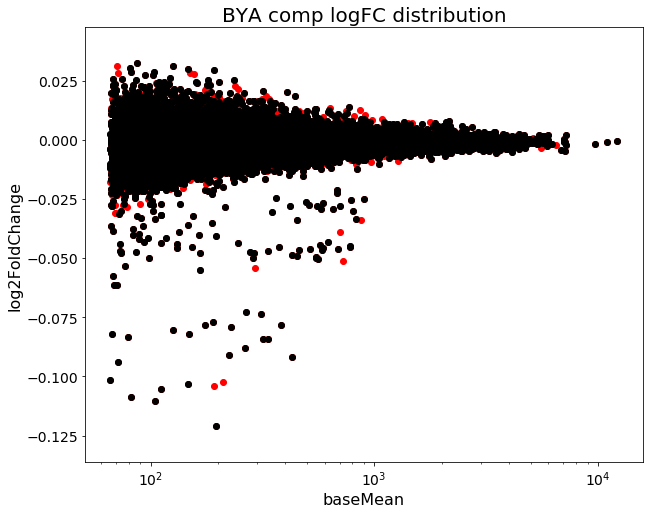

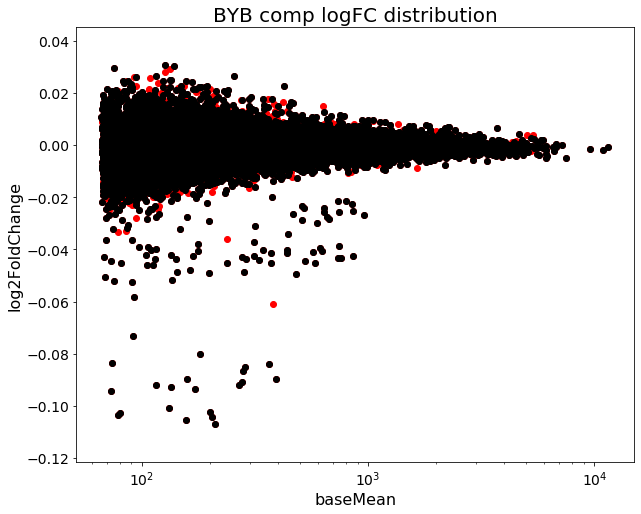

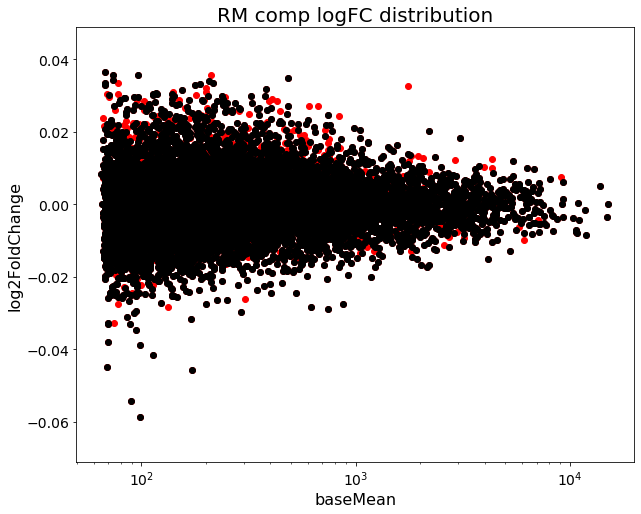

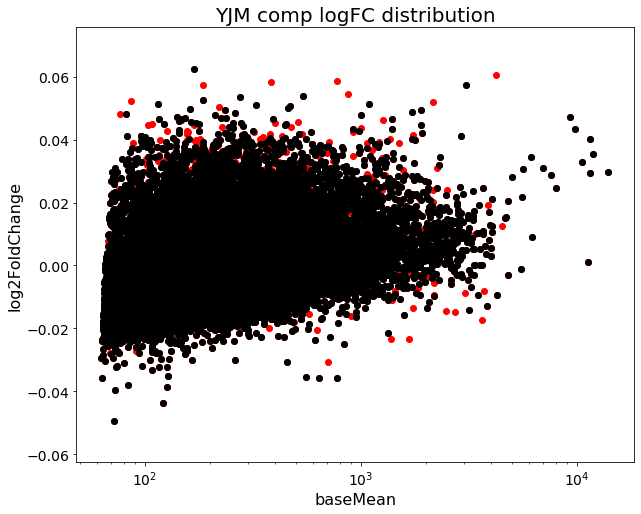

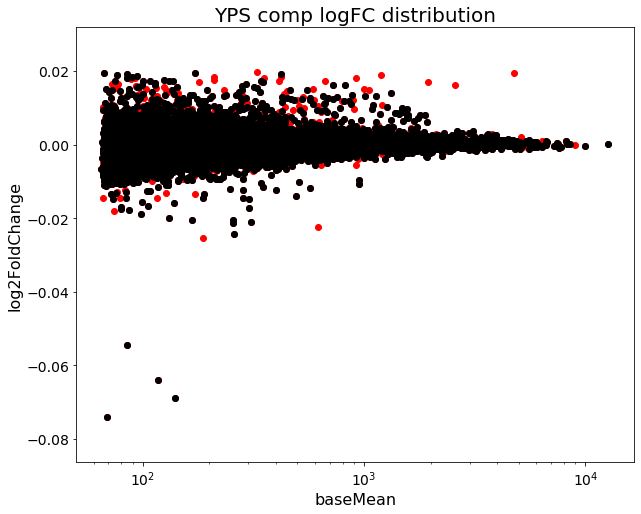

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,geno,barcode_id
barcode,,,,,,,,
003_029-6,347.985699,-0.001103,0.001557,-0.708748,0.478481,0.572585,BYA,003_029
003_029-2,101.162266,-0.000558,0.002514,-0.222096,0.824239,0.868636,BYA,003_029
003_029-1,163.308454,-0.000030,0.002525,-0.011859,0.990538,0.993198,BYA,003_029
035_001-6,438.879977,0.006642,0.001374,4.835540,0.000001,0.000008,BYA,035_001
035_001-4,492.290756,0.005013,0.001304,3.843206,0.000121,0.000449,BYA,035_001
...,...,...,...,...,...,...,...,...
Ladder_040-2,412.215311,-0.002459,0.001253,-1.962342,0.049723,0.190017,YPS,Ladder_040
Ladder_040-6,790.869826,-0.001003,0.001121,-0.895039,0.370766,0.627791,YPS,Ladder_040
Ladder_040-3,576.150447,-0.000227,0.001002,-0.226340,0.820937,0.917921,YPS,Ladder_040


In [5]:
# load oligo design table
oligo_design_df = pd.read_csv(oligo_design_file, sep='\t', header=0, index_col='barcode_id')
# subset to oligo and variant info only
annotations_df = oligo_design_df[['var_id', 'guide_id', 'oligo_id']]

# load samples info
samples_df = pd.read_csv(samples_file, sep='\t', header=0, index_col=0)

# load neutral barcodes info
neutral_barcodes_df = pd.read_csv(neutral_barcodes_file, sep='\t', header=0, index_col='barcode_id')

# load counts
counts_df = pd.read_csv(counts_file, sep='\t', header=0, index_col=0)
counts_df = counts_df[samples_df.index]

# load all DESeq2 results
deseq_results_df = []
for file in deseq_results_list:
    geno = file.split('_')[-2].upper() # extract genotype from filename
    df = pd.read_csv(file, sep='\t', header=0, index_col=0)
    df.index.name = 'barcode'
    df['geno'] = geno
    # identify oligo by barcode prefix
    df['barcode_id'] = [x.split('-')[0] for x in df.index]
    
    # plot logFC distribution
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter('baseMean', 'log2FoldChange', data=df, c='r')
    
    # keep oligos represented by 3 or more barcodes
    df = df.groupby('barcode_id').filter(lambda x: len(x)>=3)
    
    # remove outlier barcodes for each oligo
    df = df.groupby('barcode_id').apply(robust_outlier_removal).reset_index(level=0, drop=True)
    
    # replot logFC distribution
    ax.scatter('baseMean', 'log2FoldChange', data=df, c='k')
    ax.set_xlabel('baseMean', fontsize=16)
    ax.set_ylabel('log2FoldChange', fontsize=16)
    ax.set_title('{} comp logFC distribution'.format(geno), fontsize=20)
    plt.xscale('log')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    
    # append to deseq results
    deseq_results_df.append(df)

# assemble final dataframe
deseq_results_df = pd.concat(deseq_results_df, axis=0)
display(deseq_results_df)

In [6]:
# check number of barcodes filtered
for file in deseq_results_list:
    geno = file.split('_')[-2].upper() # extract genotype from filename
    df = pd.read_csv(file, sep='\t', header=0, index_col=0)
    print(geno, len(df), deseq_results_df.geno.value_counts()[geno], deseq_results_df.geno.value_counts()[geno]/len(df))

BYA 12325 11868 0.962920892494929
BYB 12265 11771 0.95972278842234
RM 10453 9924 0.9493925188940974
YJM 14966 14258 0.9526927702792998
YPS 10685 10126 0.9476836686944314


## Annotate and subset DESeq2 results table
Non-specific barcodes are removed, speeds up analyses.

In [7]:
# add annotations
deseq_results_df = deseq_results_df.merge(annotations_df[['guide_id', 'oligo_id', 'var_id']], how='inner', left_on='barcode_id', right_index=True)

# subset DESeq2 results
deseq_results_df = deseq_results_df.query('var_id.str.contains("GXG") | barcode_id.isin(@neutral_barcodes_df.index)')
# # read depth filters
# deseq_results_df = deseq_results_df.query('baseMean>=66')

display(deseq_results_df)

# subset counts matrix
counts_df = counts_df.query('barcode.isin(@deseq_results_df.index)')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,geno,barcode_id,guide_id,oligo_id,var_id
barcode,,,,,,,,,,,
035_001-6,438.879977,0.006642,0.001374,4.835540,0.000001,0.000008,BYA,035_001,guide_3995,gxg#guide_3995#guide_3995:REF2ALT:offset14:don...,GXG_00385
035_001-4,492.290756,0.005013,0.001304,3.843206,0.000121,0.000449,BYA,035_001,guide_3995,gxg#guide_3995#guide_3995:REF2ALT:offset14:don...,GXG_00385
035_001-5,242.918867,0.005667,0.001821,3.112409,0.001856,0.004983,BYA,035_001,guide_3995,gxg#guide_3995#guide_3995:REF2ALT:offset14:don...,GXG_00385
035_001-2,259.294060,-0.004298,0.001595,-2.694739,0.007044,0.016286,BYA,035_001,guide_3995,gxg#guide_3995#guide_3995:REF2ALT:offset14:don...,GXG_00385
035_001-3,424.365399,0.001051,0.001258,0.835748,0.403297,0.498609,BYA,035_001,guide_3995,gxg#guide_3995#guide_3995:REF2ALT:offset14:don...,GXG_00385
...,...,...,...,...,...,...,...,...,...,...,...
073_071-2,88.786405,-0.007212,0.002814,-2.562433,0.010394,0.068136,YPS,073_071,guide_7090,gxg#guide_7090#guide_7090:REF2ALT:offset14:don...,GXG_31877
073_071-5,92.413280,-0.004799,0.002807,-1.709877,0.087289,0.271760,YPS,073_071,guide_7090,gxg#guide_7090#guide_7090:REF2ALT:offset14:don...,GXG_31877
073_090-6,196.569022,-0.003710,0.001821,-2.037401,0.041610,0.171066,YPS,073_090,guide_8149,gxg#guide_8149#guide_8149:REF2ALT:offset14:don...,GXG_42022


## Visualize distribution of logFC values, grouped by variant
Note that neutrals are split up by oligo at this point. They can be grouped together by giving them all the same var_id when calculating var_summary

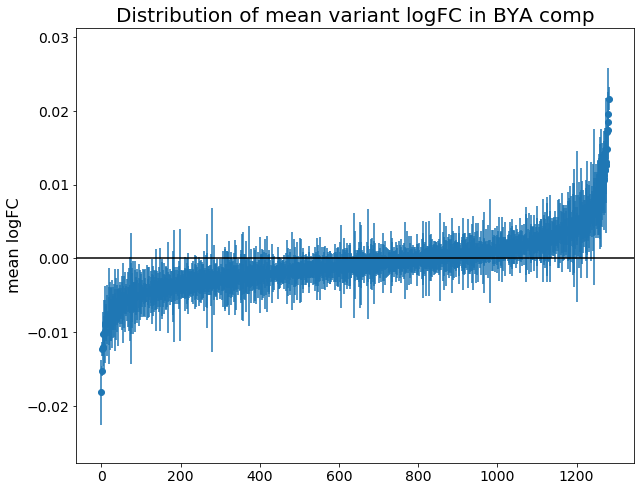

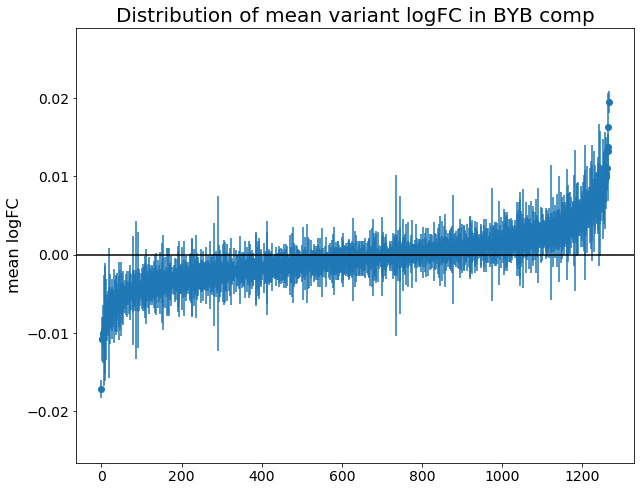

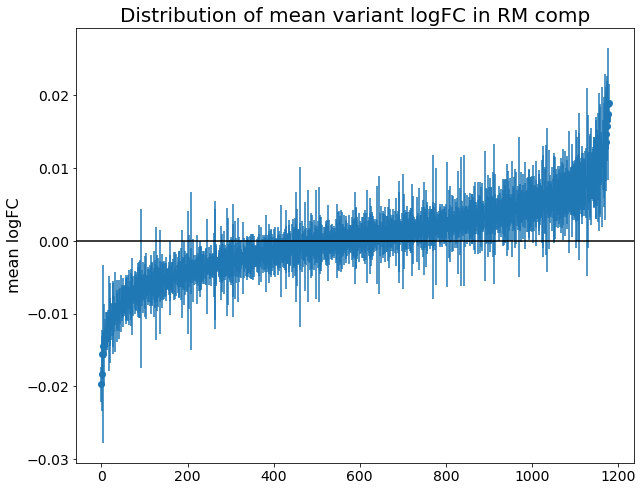

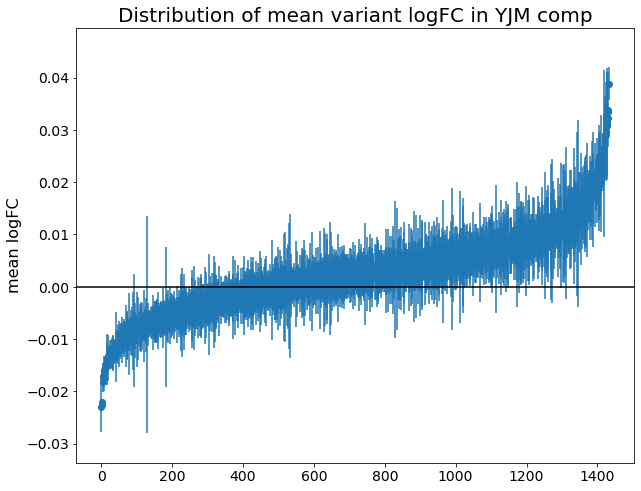

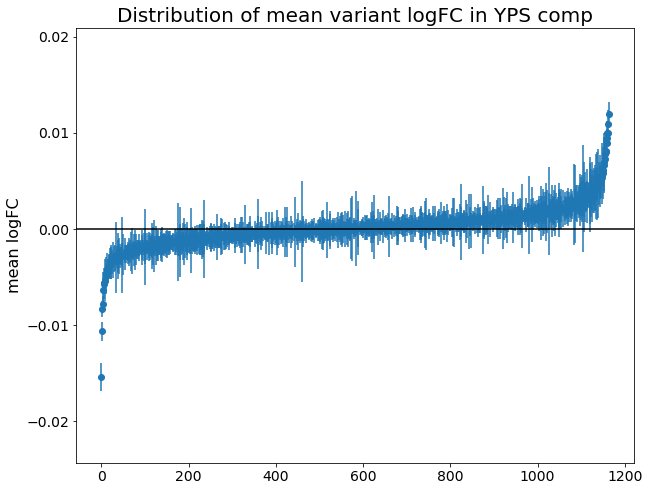

In [8]:
var_summary = deseq_results_df.groupby(['geno', 'var_id'])['log2FoldChange'].agg(['mean','sem'])

for g, viz in var_summary.groupby('geno'):
    # plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(np.arange(len(viz)), 'mean', data=viz.sort_values('mean'))
    ax.errorbar(np.arange(len(viz)), 'mean', data=viz.sort_values('mean'), yerr='sem', marker='', linestyle='')
    ax.axhline(0, color='k')
    ax.set_ylabel('mean logFC', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Distribution of mean variant logFC in {} comp'.format(g), fontsize=20)
    plt.show()

### (optional) do t-test on each variant to identify significant fitness effects
The unweighted t-test gives a general idea for how many significant fitness effects to expect from the data. Note that this does not account for heteroscedasticity and should only be used as rough guide to check the WLS output.

Statsmodels' implementation of t-test also gives you the option to implement frequency weights. This should be comparable to what you will find from weighted least squares regression

In [9]:
test_df = deseq_results_df.query('~barcode_id.isin(@neutral_barcodes_df.index)')
neutral_df = deseq_results_df.query('barcode_id.isin(@neutral_barcodes_df.index)')

# run unweighted t-test for each variant, comparing against neutral barcode distribution
ttest_results = pd.Series()
for l, df in test_df.groupby(['geno', 'var_id']):
    g, var = l
    test = df.query('geno==@g').groupby('var_id').apply(lambda x: ttest_ind(x['log2FoldChange'], neutral_df.query('geno==@g')['log2FoldChange']))
    ttest_results = pd.concat([ttest_results, pd.concat([test], keys=[g])])

ttest_results = pd.DataFrame.from_records(ttest_results, index=ttest_results.index, columns=['t', 'pvalue', 'df'])
ttest_results.index = pd.MultiIndex.from_tuples(ttest_results.index, names=['geno', 'var_id'])
ttest_results['padj'] = multipletests(ttest_results['pvalue'], method='fdr_bh')[1]

# add t-test results to var_summary
var_summary = var_summary.merge(ttest_results, how='inner', left_index=True, right_index=True).sort_values('padj')
display(var_summary)

mean       sem          t        pvalue     df  \
geno var_id                                                          
YPS  GXG_41284  0.011944  0.001292  14.066571  7.022332e-39  580.0   
     GXG_43565 -0.010665  0.001006 -13.317150  1.676428e-35  581.0   
     GXG_14759  0.010919  0.001470  12.240384  8.448012e-31  579.0   
     GXG_14686  0.009478  0.000897  11.270356  8.876397e-27  580.0   
     GXG_14714  0.007794  0.001572  10.036079  5.694179e-22  583.0   
...                  ...       ...        ...           ...    ...   
     GXG_16385  0.000055  0.000576   0.001761  9.985952e-01  575.0   
BYB  GXG_39161  0.000061  0.001157  -0.000942  9.992484e-01  662.0   
RM   GXG_37459  0.000076  0.002213   0.000592  9.995278e-01  551.0   
YJM  GXG_27653  0.000100  0.012087   0.000727  9.994201e-01  620.0   
BYB  GXG_10816  0.000064  0.000411   0.000381  9.996961e-01  661.0   

                        padj  
geno var_id                   
YPS  GXG_41284  4.252022e-35  
     GXG_43565  5.075387e-32  
     GXG_14759  1.705090e-27  
     GXG_14686  1.343665e-23  
     GXG_14714  6.895650e-19  
...                      ...  
     GXG_16385  9.992554e-01  
BYB  GXG_39161  9.996929e-01  
RM   GXG_37459  9.996929e-01  
YJM  GXG_27653  9.996929e-01  
BYB  GXG_10816  9.996961e-01  

[6055 rows x 6 columns]

In [10]:
# run weighted t-test 
w_ttest_results = pd.Series()
for l, df in test_df.groupby(['geno', 'var_id']):
    g, var = l
    w_test = df.query('geno==@g').groupby('var_id').apply(lambda x: ttest_ind(x['log2FoldChange'].values, neutral_df.query('geno==@g')['log2FoldChange'].values,
                                                                              weights=( (1/(x['lfcSE']**2) / (1/( pd.concat([x, neutral_df.query('geno==@g')])['lfcSE']**2)).mean()).values, 
                                                                                        (1/(neutral_df.query('geno==@g')['lfcSE']**2) / (1/( pd.concat([x, neutral_df.query('geno==@g')])['lfcSE']**2)).mean()).values ) ))
    w_ttest_results = pd.concat([w_ttest_results, pd.concat([w_test], keys=[g])])

w_ttest_results = pd.DataFrame.from_records(w_ttest_results, index=w_ttest_results.index, columns=['w_t', 'w_pvalue', 'w_df'])
w_ttest_results.index = pd.MultiIndex.from_tuples(w_ttest_results.index, names=['geno', 'var_id'])
# adjust dtype due to weird array formatting
w_ttest_results['w_t'] = w_ttest_results['w_t'].astype(np.float64)
w_ttest_results['w_pvalue'] = w_ttest_results['w_pvalue'].astype(np.float64)
w_ttest_results['w_df'] = w_ttest_results['w_df'].astype(np.float64)
w_ttest_results['w_padj'] = multipletests(w_ttest_results['w_pvalue'], method='fdr_bh')[1]

# add weighted t-test results to var_summary
var_summary = var_summary.merge(w_ttest_results, how='inner', left_index=True, right_index=True).sort_values('w_padj')
display(var_summary)

mean       sem          t        pvalue     df  \
geno var_id                                                          
YPS  GXG_43565 -0.010665  0.001006 -13.317150  1.676428e-35  581.0   
     GXG_14759  0.010919  0.001470  12.240384  8.448012e-31  579.0   
     GXG_46576  0.008904  0.000589   7.887389  1.561397e-14  575.0   
     GXG_41284  0.011944  0.001292  14.066571  7.022332e-39  580.0   
     GXG_14686  0.009478  0.000897  11.270356  8.876397e-27  580.0   
...                  ...       ...        ...           ...    ...   
     GXG_31402  0.000346  0.001203   0.212922  8.314635e-01  573.0   
RM   GXG_43556  0.000479  0.001430   0.097003  9.227591e-01  552.0   
     GXG_02247 -0.001384  0.001262  -0.649139  5.165140e-01  562.0   
BYA  GXG_01678 -0.000692  0.001465  -0.379943  7.041071e-01  676.0   
     GXG_41927 -0.002288  0.003898  -0.789963  4.298299e-01  668.0   

                        padj        w_t      w_pvalue   w_df        w_padj  
geno var_id                                                                 
YPS  GXG_43565  5.075387e-32 -16.863674  3.117982e-52  581.0  1.887938e-48  
     GXG_14759  1.705090e-27  12.636971  1.680536e-32  579.0  5.087822e-29  
     GXG_46576  1.050473e-11  12.281027  5.968127e-31  575.0  1.204567e-27  
     GXG_41284  4.252022e-35  12.093619  3.493637e-30  580.0  5.288493e-27  
     GXG_14686  1.343665e-23  10.064798  4.525725e-22  580.0  5.480653e-19  
...                      ...        ...           ...    ...           ...  
     GXG_31402  9.403050e-01   0.003153  9.974850e-01  573.0  9.996542e-01  
RM   GXG_43556  9.663276e-01  -0.003648  9.970909e-01  552.0  9.996542e-01  
     GXG_02247  7.949904e-01   0.002408  9.980798e-01  562.0  9.996542e-01  
BYA  GXG_01678  8.917755e-01   0.000890  9.992904e-01  676.0  9.996542e-01  
     GXG_41927  7.395908e-01   0.000020  9.999837e-01  668.0  9.999837e-01  

[6055 rows x 10 columns]

### (optional) visualize neutral barcode distribution
This enables you to check the extent of heteroscedasticity in logFC values across read depths, as well as potential outliers  that may interfere with WLS. In some cases, skews in logFC distribution may be correctable in the WLS design.

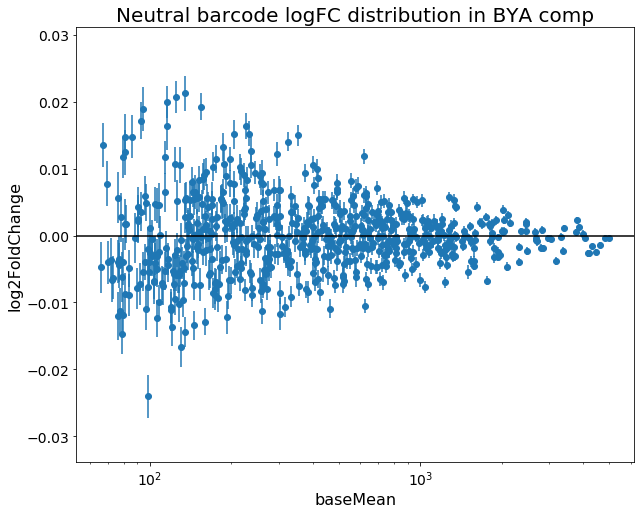

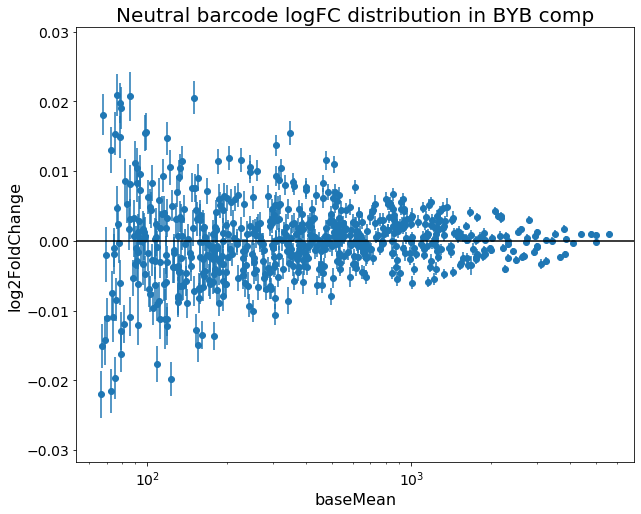

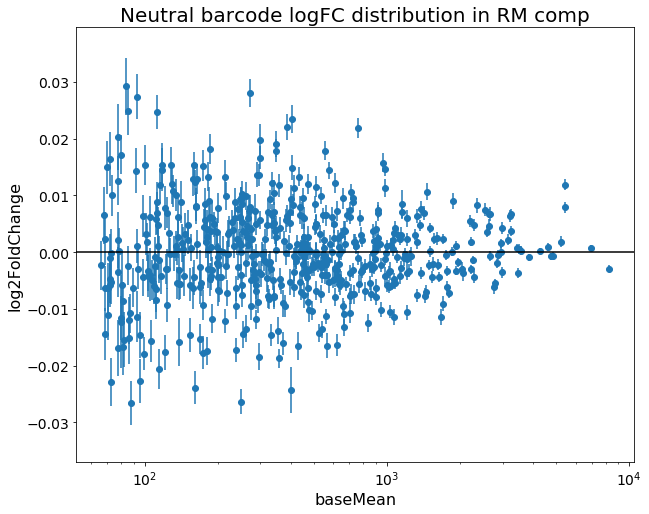

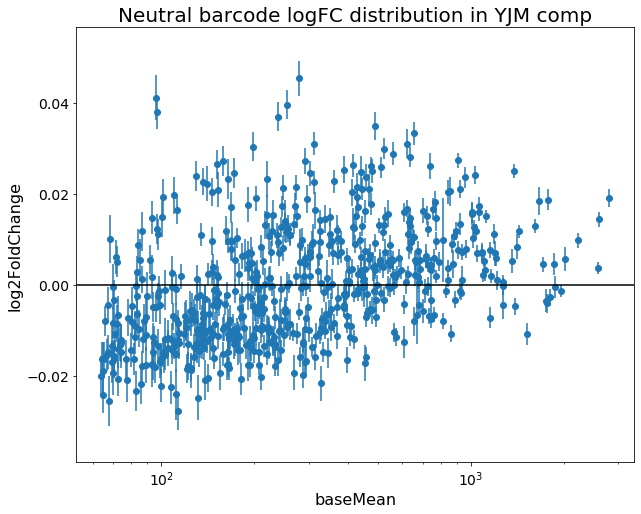

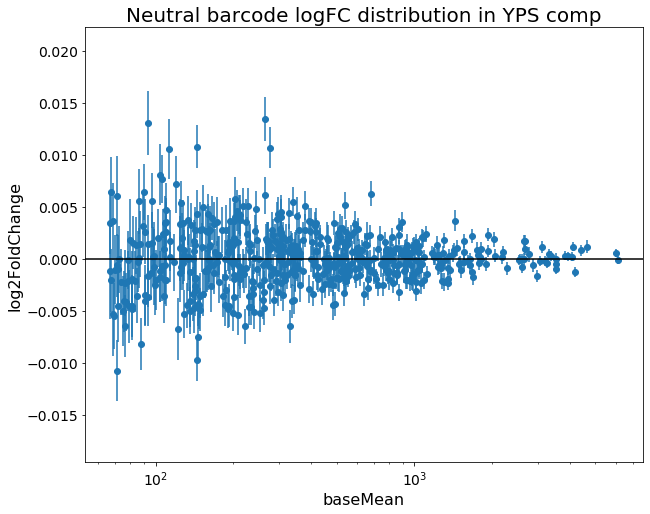

In [11]:
x = 'baseMean'
y = 'log2FoldChange'
y_error = 'lfcSE'

for g, viz in deseq_results_df.query('barcode_id.isin(@neutral_barcodes_df.index)').groupby('geno'):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(x, y, data=viz)
    ax.errorbar(x, y, data=viz, yerr=y_error, marker='', linestyle='')    
    plt.axhline(0, color='k')

    ax.set_xlabel(x, fontsize=16)
    ax.set_ylabel(y, fontsize=16)
    ax.set_title('Neutral barcode logFC distribution in {} comp'.format(g), fontsize=20)
    plt.xscale('log')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()

## Fit DESeq2 results into weighted least squares regression

In [12]:
# prepare input data
d = deseq_results_df.copy()
d.loc[d['barcode_id'].isin(neutral_barcodes_df.index), 'var_id'] = '.NEUTRAL' # sets neutral barcodes as reference
d['log_count'] = np.log10(d['baseMean'])

# formula = 'log2FoldChange ~ C(var_id)'
# formula = 'log2FoldChange ~ C(var_id) + C(geno) + C(var_id):C(geno)' # includes interaction term with condition of interest
formula = 'log2FoldChange ~ log_count + C(var_id) + C(geno) + log_count:C(geno) + C(var_id):C(geno)'# 

w = 1/d['lfcSE']**2 

wls_res = wls(formula, data=d, weights=w).fit()
wls_res.summary()

/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/groups/hbfraser/modules/packages/conda/4.6.14/envs/crispey-bar/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:         log2FoldChange   R-squared:                       0.287
Model:                            WLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     3.293
Date:                Fri, 03 Sep 2021   Prob (F-statistic):               0.00
Time:                        23:38:22   Log-Likelihood:             2.0470e+05
No. Observations:               55595   AIC:                        -3.973e+05
Df Residuals:                   49530   BIC:                        -3.431e+05
Df Model:                        6064                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.0028      0.001     -5.525      0.000      -0.004      -0.002
C(var_id)[T.GXG_00329]                   -0.0006      0.001     -0.638      0.523      -0.003       0.001
C(var_id)[T.GXG_00332]                    0.0041      0.002      1.678      0.093      -0.001       0.009
C(var_id)[T.GXG_00346]                    0.0020      0.002      1.006      0.314      -0.002       0.006
C(var_id)[T.GXG_00347]                    0.0033      0.004      0.906      0.365      -0.004       0.011
C(var_id)[T.GXG_00366]                    0.0007      0.001      0.693      0.489      -0.001       0.003
C(var_id)[T.GXG_00374]                   -0.0007      0.002     -0.437      0.662      -0.004       0.003
C(var_id)[T.GXG_00384]                 2.369e-05      0.004      0.006      0.995      -0.008       0.008
C(var_id)[T.GXG_00385]                    0.0019      0.001      1.294      0.196      -0.001       0.005
C(var_id)[T.GXG_00387]                    0.0014      0.002      0.599      0.549      -0.003       0.006
C(var_id)[T.GXG_00422]                    0.0017      0.004      0.438      0.661      -0.006       0.009
C(var_id)[T.GXG_00437]                    0.0028      0.004      0.677      0.498      -0.005       0.011
C(var_id)[T.GXG_00439]                   -0.0010      0.004     -0.237      0.813      -0.009       0.007
C(var_id)[T.GXG_00440]                   -0.0014      0.004     -0.350      0.726      -0.009       0.006
C(var_id)[T.GXG_00441]                    0.0048      0.004      1.216      0.224      -0.003       0.013
C(var_id)[T.GXG_00445]                   -0.0031      0.002     -1.584      0.113      -0.007       0.001
C(var_id)[T.GXG_00447]                   -0.0027      0.001     -3.577      0.000      -0.004      -0.001
C(var_id)[T.GXG_00452]                   -0.0016      0.001     -2.366      0.018      -0.003      -0.000
C(var_id)[T.GXG_00458]                   -0.0023      0.001     -2.577      0.010      -0.004      -0.001
C(var_id)[T.GXG_00462]                   -0.0012      0.002     -0.710      0.478      -0.005       0.002
C(var_id)[T.GXG_00475]                   -0.0010      0.002     -0.467      0.640      -0.005       0.003
C(var_id)[T.GXG_00476]                   -0.0013      0.001     -0.889      0.374      -0.004       0.002
C(var_id)[T.GXG_00480]                    0.0009      0.001      0.621      0.535      -0.002       0.004
C(var_id)[T.GXG_00483]                   -0.0035      0.002     -2.047      0.041      -0.007      -0.000
C(var_id)[T.GXG_00490]                   -0.0010      0.001     -0.979      0.328      -0.003       0.001
C(var_id)[T.GXG_00492]                   -0.0037      0.002     -2.157      0.031      -0.007      -0.000
C(var_id)

## Calculate variant fitness from WLS model
Use calc_var_fitness as a wrapper for extracting the fitness values from WLS model. It can also calculate fitness in non-reference conditions as well, by supplying the appropriate terms in the "conditions" variable.

These functions were tested under the simplest WLS implementations (i.e. one interaction term between fitness and condition), and are not guaranteed to work for more complex fits with multiple interaction terms.

In [13]:
var_dict = dict(d.query('~barcode_id.isin(@neutral_barcodes_df.index)').groupby('var_id').apply(lambda x: list(x.geno.unique())) )
var_fitness_df = pd.concat([calc_var_fitness(var, wls_res, geno_list) for var, geno_list in var_dict.items()], join='inner', axis=0)

# adjust formatting
var_fitness_df.index = pd.MultiIndex.from_tuples(var_fitness_df.index.str.split(',').tolist(), names=['var_id', 'geno'])
var_fitness_df = var_fitness_df.reset_index()
# calc padj
var_fitness_df = var_fitness_df.rename(columns={'P>|t|': 'pval'})
var_fitness_df['padj'] = multipletests(var_fitness_df['pval'], alpha=0.05, method='fdr_bh')[1]
display(var_fitness_df.sort_values('padj'))

# write to file
var_fitness_df.to_csv(var_fitness_file, sep='\t', header=True)

,var_id,geno,coef,std err,t,pval,Conf. Int. Low,Conf. Int. Upp.,padj
5488,GXG_46593,YJM,-9.906744e-03,0.001168,-8.482798,2.258212e-17,-0.012196,-0.007618,1.367347e-13
5087,GXG_43565,YPS,-1.035371e-02,0.001233,-8.395000,4.780467e-17,-0.012771,-0.007936,1.447286e-13
723,GXG_05112,YJM,2.823844e-02,0.003389,8.332707,8.101568e-17,0.021596,0.034881,1.635167e-13
2945,GXG_25327,YJM,-1.214818e-02,0.001511,-8.039275,9.235512e-16,-0.015110,-0.009186,1.398026e-12
3587,GXG_31417,YJM,-1.547077e-02,0.002018,-7.668244,1.775384e-14,-0.019425,-0.011516,2.149990e-11
...,...,...,...,...,...,...,...,...,...
3944,GXG_33813,YPS,2.585657e-05,0.004375,0.005910,9.952846e-01,-0.008549,0.008601,9.985863e-01
3139,GXG_26457,BYA,1.646476e-06,0.000843,0.001954,9.984412e-01,-0.001650,0.001653,9.989361e-01
1028,GXG_06802,BYB,-5.625764e-06,0.004504,-0.001249,9.990033e-01,-0.008833,0.008821,9.993334e-01
5787,GXG_48513,YPS,1.946100e-07,0.000976,0.000199,9.998410e-01,-0.001913,0.001914,9.998410e-01


## Calculate GxG interactions from WLS model
Use calc_cond_interactions as a wrapper for calculating condition-specific interaction terms between conditions (e.g. genotype, environment, etc.) in WLS model. It can calculates interactions between all condition pairs supplied in the "conditions" variable.

These functions were tested under the simplest WLS implementations (i.e. one interaction term between fitness and condition), and are not guaranteed to work for more complex fits with multiple interaction terms.

In [14]:
var_dict = dict(d.query('~barcode_id.isin(@neutral_barcodes_df.index)').groupby('var_id').apply(lambda x: list(x.geno.unique())) )
gxg_df = pd.concat([calc_cond_interactions(var, wls_res, geno_list) for var, geno_list in var_dict.items() if len(geno_list)>=2], join='inner', axis=0)

# # adjust formatting
gxg_df.index = pd.MultiIndex.from_tuples(gxg_df.index.str.split(':').tolist(), names=['var_id', 'gxg'])
gxg_df = gxg_df.reset_index()
# calc padj
gxg_df = gxg_df.rename(columns={'P>|t|': 'pval'})
gxg_df['padj'] = multipletests(gxg_df['pval'], alpha=0.05, method='fdr_bh')[1]
display(gxg_df.sort_values('padj'))

# write to file
gxg_df.to_csv(gxg_interactions_file, sep='\t', header=True)

,var_id,gxg,coef,std err,t,pval,Conf. Int. Low,Conf. Int. Upp.,padj
9848,GXG_46593,YJM-YPS,-0.012142,0.001294,-9.382290,6.718623e-21,-0.014679,-0.009606,7.304487e-17
9846,GXG_46593,RM-YJM,0.012555,0.001403,8.945861,3.814797e-19,0.009804,0.015305,2.073724e-15
5305,GXG_25327,YJM-YPS,-0.012590,0.001596,-7.886620,3.167958e-15,-0.015719,-0.009461,1.148068e-11
3258,GXG_14714,YJM-YPS,-0.017128,0.002186,-7.836296,4.732330e-15,-0.021412,-0.012844,1.286247e-11
10017,GXG_47227,RM-YJM,-0.016106,0.002090,-7.706844,1.313607e-14,-0.020202,-0.012010,2.856307e-11
...,...,...,...,...,...,...,...,...,...
994,GXG_02525,BYA-YPS,0.000006,0.004638,0.001347,9.989256e-01,-0.009085,0.009097,9.992864e-01
4703,GXG_21904,BYA-BYB,-0.000007,0.005697,-0.001170,9.990666e-01,-0.011174,0.011160,9.992864e-01
2602,GXG_11131,BYB-YPS,-0.000002,0.002709,-0.000911,9.992732e-01,-0.005313,0.005308,9.992864e-01
2559,GXG_10817,BYB-RM,-0.000006,0.006721,-0.000922,9.992642e-01,-0.013179,0.013167,9.992864e-01


### (optional) write WLS model summary table to file

In [15]:
file = open("gxg_5comp_wls_summary.txt", "w")
file.write(wls_res.summary().as_csv())
file.close()

### (optional) load ladder oligo annotations and ladder pilot deseq results, add to annotations table
The oligo design file does not include the 43 ladder oligos designed for CRISPEY3 pilot, so add it from separate file

In [ ]:
# ladder oligos annotations
ladder_annotations_file = "/home/users/rang/crispey3/ladder_pilot_feb2021/ladder_oligos_annotated.txt"
# ladder pilot deseq results
ladder_pilot_deseq_file = "/home/users/rang/crispey3/ladder_pilot_feb2021/deseq/ladder_pilot_deseq_results.txt"

In [ ]:
# load ladder pilot annotations
ladder_annotations_df = pd.read_csv(ladder_annotations_file, sep='\t', header=0, index_col=0)
ladder_annotations_df['oligo_id'] = ['tech_{}_hdr'.format(orf) for orf in ladder_annotations_df["ORF"]]
ladder_annotations_df['barcode_id'] = ['Ladder_{:0>3}'.format(int(x.split("_")[-1])+1) for x in ladder_annotations_df['Name']]

# load ladder pilot deseq data and append to ladder annotations
ladder_pilot_deseq_df = pd.read_csv(ladder_pilot_deseq_file, sep=',', header=0, index_col=0)
ladder_annotations_df = ladder_annotations_df.merge(ladder_pilot_deseq_df, how='left', left_on='PBC', right_index=True)
ladder_annotations_df = ladder_annotations_df[['barcode_id', 'oligo_id', 'breslow_growth_rate', 'log2FoldChange']]
ladder_annotations_df = ladder_annotations_df.rename(columns={'log2FoldChange':'pilot_logFC'})

# combine information to get complete ladder annotations df with breslow and pilot fitness data
ladder_annotations_df = ladder_annotations_df.merge(annotations_df, on='oligo_id', how='left').drop_duplicates().set_index('barcode_id')
# fill info for barcode "Ladder_40"
ladder_annotations_df.loc['Ladder_040', "var_id"] = "hdr_43"
ladder_annotations_df.loc['Ladder_040', "guide_id"] = "technical_999"
display(ladder_annotations_df)

# add to annotations table
annotations_df = pd.concat([annotations_df, ladder_annotations_df[annotations_df.columns]])
display(annotations_df)

### (optional) calculate normalized counts
useful for visualizing individual barcodes across time points

In [ ]:
counts_norm_df = counts_df.copy()
counts_norm_df = counts_norm_df[counts_norm_df.sum(axis=1)>=1000] # same read filter as DESeq2
counts_norm_df = counts_norm_df/counts_norm_df.sum(axis=0) * 1e6  #cpm
counts_norm_df = np.log2(counts_norm_df+1e-6) #log2(cpm), with 1 pseudocount
display(counts_norm_df)


### (optional) check a variant logFC distribution against neutral barcodes

In [ ]:
g = 'BYA'
var = 'GXG_00384'

# plot
x = 'baseMean'
y = 'log2FoldChange'
y_error = 'lfcSE'

fig, ax = plt.subplots(figsize=(10,8))
# neutrals
ax.errorbar(x, y, data=deseq_results_df.query('geno==@g & barcode_id.isin(@neutral_barcodes_df.index)'), yerr=y_error, label='neutral', marker='o', linestyle='')
# variant, split by oligo
for b, df in deseq_results_df.query('geno==@g & var_id==@var').groupby('barcode_id'):
    ax.errorbar(x, y, data=df, yerr=y_error, label="{}, barcode {}".format(var, b), marker='o', linestyle='')
plt.axhline(0, color='k')

ax.set_xlabel('avg reads per sample', fontsize=16)
ax.set_ylabel('logFC', fontsize=16)
ax.set_title('{} vs neutral logFC'.format(var), fontsize=20)
plt.xscale('log')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()
plt.show()